In [1]:
from typing import TypedDict, Annotated

from langgraph.constants import START
from langgraph.graph import StateGraph, END, add_messages
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv

load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END


tool_node = ToolNode(tools=tools)

subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

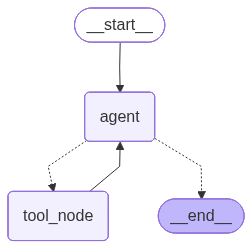

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [3]:
search_app.invoke({"messages": [HumanMessage(content="How is the weather today in Colombo?")]})

{'messages': [HumanMessage(content='How is the weather today in Colombo?', additional_kwargs={}, response_metadata={}, id='042f57ce-60e7-46b9-8af7-70de8cc9a510'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'vn5114tw5', 'function': {'arguments': '{"query":"Colombo weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 287, 'total_tokens': 308, 'completion_time': 0.03535166, 'prompt_time': 0.019177554, 'queue_time': 0.062784035, 'total_time': 0.054529214}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-77445199-afaf-4f15-9230-a74d75a0de88-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Colombo weather today'}, 'id': 'vn5114tw5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 287, 'output_tokens': 21, 'total_tokens': 308}),
  ToolMessage(content='

Case1: Shared Schema (Directly embedding)

In [5]:
from langgraph.graph import START

class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

#Create parent graph
parent_graph = StateGraph(ParentState)

#Adding the subgraph as a node
parent_graph.add_node("search_agent", search_app)

parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()

result = parent_app.invoke({
    "messages": [HumanMessage(content="How is the weather today in Colombo?")]
})
print(result)

{'messages': [HumanMessage(content='How is the weather today in Colombo?', additional_kwargs={}, response_metadata={}, id='0a1ded35-991c-41e7-8779-f1d230533f78'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'h3y0sf7bs', 'function': {'arguments': '{"query":"Colombo weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 287, 'total_tokens': 308, 'completion_time': 0.044877373, 'prompt_time': 0.022310668, 'queue_time': 0.055056692, 'total_time': 0.067188041}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b8f7eba2-5d79-467e-9f34-bdf48a6ae06c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Colombo weather today'}, 'id': 'h3y0sf7bs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 287, 'output_tokens': 21, 'total_tokens': 308}), ToolMessage(content='[{"

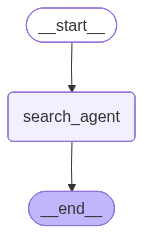

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        parent_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

Case 2: Different Schema (Invoke with Transformation)

In [7]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }

    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)

    # Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather today in Colombo?", "response": ""})
print(result)

{'query': 'How is the weather today in Colombo?', 'response': 'The weather in Colombo today is expected to be hazy with sunshine and high cloud, but light rain later with a maximum temperature of 30 degrees Celsius.'}


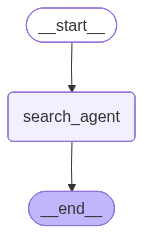

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        parent_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)